# Mountain Car Project

## Required installation and Import Libiraries

In [ ]:
! pip install -q pyglet==1.5.0
! pip install -q gym[all]
! pip install -q keras
! pip install -q tensorflow

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Nourhan\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Nourhan\\AppData\\Local\\Temp\\pip-install-uc8r570f\\box2d-py_3619c3d9902e4ffc9df3bf251888c8f2\\setup.py'"'"'; __file__='"'"'C:\\Users\\Nourhan\\AppData\\Local\\Temp\\pip-install-uc8r570f\\box2d-py_3619c3d9902e4ffc9df3bf251888c8f2\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Nourhan\AppData\Local\Temp\pip-wheel-vl36hx3w'
       cwd: C:\Users\Nourhan\AppData\Local\Temp\pip-install-uc8r570f\box2d-py_3619c3d9902e4ffc9df3bf251888c8f2\
  Complete output (16 lines):
  Using setuptools (version 58.0.4).
  running bdist_wheel
  running build
  running build_py
  creat

In [ ]:
import numpy as np
import random
import collections
from collections import deque
import random
import sys
import gym
import pylab
import matplotlib.pyplot as plt
from IPython import display
from collections import deque
from keras.models import model_from_json
from keras import layers
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense,Activation
from keras.layers import LeakyReLU
from keras.initializers import he_normal,RandomNormal
from tensorflow.keras.optimizers import SGD

## Build Agent(Car) Function

In [ ]:
class MountainCarAgent():

    def __init__(self, action_size, state_size, discount_factor, learning_rate,
                       epsilon, epsilon_decay, epsilon_min):

        # parameters
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_max = 1    
        self.load_model = True
        self.epsilon_min = epsilon_min
        self.batch_size = 32
        self.memory = deque(maxlen=2000)

        # action and state sizes
        self.action_size = action_size
        self.state_size = state_size

        # build the NN model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        initializer = he_normal(seed = 1000)
        model = Sequential()
        model.add(Dense(48, input_dim=2,kernel_initializer = initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(64,kernel_initializer = initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(self.action_size, activation=LeakyReLU(alpha=0.1),kernel_initializer = initializer))
        model.compile(loss="mean_squared_error",optimizer=Adam(lr = 0.0001))
        return model

    def get_action(self, state):         
        if random.uniform(0, 1) <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)       
            return np.argmax(q_value[0])
    
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train_model(self):
        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.target_model.predict(update_output)
            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])            
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0,validation_split = 0.1)

    def save_model_weights(self, name):
        self.model.save_weights(name)

### Get environment

In [ ]:
# get environment
env = gym.make('MountainCar-v0')
env.reset()

array([-0.59669447,  0.        ], dtype=float32)

In [ ]:
state_size = env.observation_space.shape[0] 
action_size = env.action_space.n 

## Train the agent

In [ ]:
n_episodes = 40

In [ ]:
def train_agent(agent,nam, rewards_per_episode, for_steps,episodes,ep_re, ep_st,update_counter,epsilon ):
     
    for episode in range(n_episodes):

        done = False
        score = 0
          # reset at the start of each episode
        state = env.reset()
        steps=0
        while not done:
            env.render()
            agent.epsilon = 0.01 + (1 - 0.01) * np.exp(-0.001*update_counter)
            update_counter = update_counter + 1
                # get action for the current state and take a step in the environment
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            reward = 100*((np.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
            if next_state[0] >= 0.5:
                reward += 1
            agent.append_sample(state,action, reward, next_state,done)

            # train after each step
            agent.train_model()

            # add reward to the total score of this episode and number of steps
            state = next_state
            steps+=1
            score += reward
            if done:
                agent.update_target_model()

        # store total reward obtained in this episode
        for_steps.append(steps)
        rewards_per_episode.append(score)
        episodes.append(episode)
        if score == np.max(rewards_per_episode) :
            ep_re= episode
        if steps== np.min(for_steps):
            ep_st= episode
        # every episode:
        print("episode {0}, reward {1}, memory_length {2}, Number of Steps {3}, epsilon {4}".format(episode,score,len(agent.memory),steps, agent.epsilon))
        # terminate if no major learning for previous 5 episodes
        if np.mean(rewards_per_episode[-5:]) > 1.5 :
            break;
          # every few episodes:
        if episode > 1 and episode % 5 == 0:
            # save model weights
            agent.save_model_weights(name=nam)
            
    return rewards_per_episode, for_steps, ep_re, ep_st

### First Trial with discount=0.95, lr=0.02

In [ ]:
agent_1=  MountainCarAgent(action_size, state_size, discount_factor=0.95, learning_rate=0.02,
                          epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)

C:\Users\Nourhan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
re_1, ste_1, ep_re1, ep_st1=train_agent(agent_1,nam="model_weights_1.h5", rewards_per_episode=[], for_steps=[],
                                        episodes=[],ep_re=0, ep_st=0,update_counter=0,epsilon = 1)
re1=np.array(re_1).max()
ste1=np.array(ste_1).min()

1/1 [==============================] - 0s 20ms/step
episode 0, reward 0.019062840400020913, memory_length 200, Number of Steps 200, epsilon 0.8213543943995963
1/1 [==============================] - 0s 24ms/step
episode 1, reward 0.07311914075077913, memory_length 400, Number of Steps 200, epsilon 0.6742807943399114
1/1 [==============================] - 0s 16ms/step
episode 2, reward 0.339201208946779, memory_length 600, Number of Steps 200, epsilon 0.5538671150051557
1/1 [==============================] - 0s 18ms/step
episode 3, reward 0.2671519439321927, memory_length 800, Number of Steps 200, epsilon 0.4552807326425205
1/1 [==============================] - 0s 18ms/step
episode 4, reward 0.07728499338418515, memory_length 1000, Number of Steps 200, epsilon 0.3745650295675263
1/1 [==============================] - 0s 19ms/step
episode 5, reward 0.20689475175814143, memory_length 1200, Number of Steps 200, epsilon 0.3084806012037175
1/1 [==============================] - 0s 19ms/step


Average reward of last 100 episodes is 1.5927295427002663


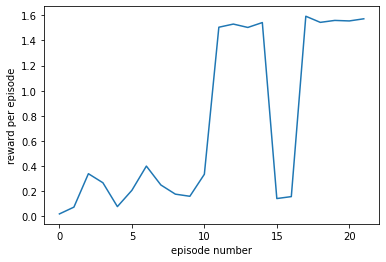

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.max(re_1[-100:])))
plt.plot(list(range(len(re_1))), re_1)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

Average reward of last 100 episodes is 133


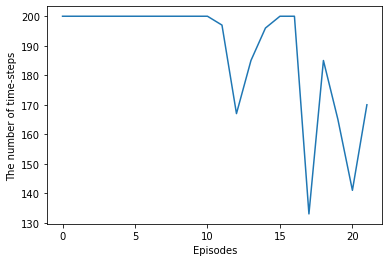

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.min(ste_1[-100:])))
plt.plot(list(range(len(ste_1))), ste_1)
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

### Second Trial with discount=0.8 and lr=0.005

In [ ]:
agent_2=  MountainCarAgent(action_size, state_size, discount_factor=0.8, learning_rate=0.005,
                          epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)

In [ ]:
re_2,ste_2, ep_re2, ep_st2=train_agent(agent_2,nam="model_weights_2.h5", rewards_per_episode=[], for_steps=[],
                                        episodes=[],ep_re=0, ep_st=0,update_counter=0,epsilon = 1)
re2=np.array(re_2).max()
ste2=np.array(ste_2).min()

1/1 [==============================] - 0s 18ms/step
episode 0, reward 0.08434348170211202, memory_length 200, Number of Steps 200, epsilon 0.8213543943995963
1/1 [==============================] - 0s 19ms/step
episode 1, reward 0.179904544945693, memory_length 400, Number of Steps 200, epsilon 0.6742807943399114
1/1 [==============================] - 0s 16ms/step
episode 2, reward 0.031532350784702366, memory_length 600, Number of Steps 200, epsilon 0.5538671150051557
1/1 [==============================] - 0s 20ms/step
episode 3, reward 0.08276114286892336, memory_length 800, Number of Steps 200, epsilon 0.4552807326425205
1/1 [==============================] - 0s 18ms/step
episode 4, reward 0.07655054843721629, memory_length 1000, Number of Steps 200, epsilon 0.3745650295675263
1/1 [==============================] - 0s 19ms/step
episode 5, reward 0.3498017711892982, memory_length 1200, Number of Steps 200, epsilon 0.3084806012037175
1/1 [==============================] - 0s 18ms/step


Average reward of last 100 episodes is 1.5305842611064762


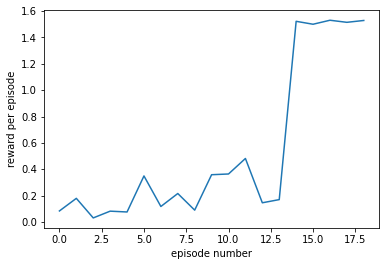

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.max(re_2[-100:])))
plt.plot(list(range(len(re_2))), re_2)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

Average reward of last 100 episodes is 161


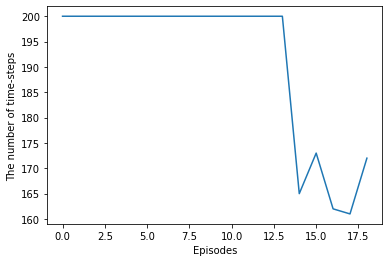

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.min(ste_2[-100:])))
plt.plot(list(range(len(ste_2))), ste_2)
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

### Third Trial with discount= 0.6 and lr=0.5

In [ ]:
agent_3=  MountainCarAgent(action_size, state_size, discount_factor=0.6, learning_rate=0.5,
                          epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)

In [ ]:
re_3, ste_3, ep_re3, ep_st3=train_agent(agent_3, nam="model_weights_3.h5", rewards_per_episode=[], for_steps=[],
                                        episodes=[],ep_re=0, ep_st=0,update_counter=0,epsilon = 1)
re3=np.array(re_3).max()
ste3=np.array(ste_3).min()

1/1 [==============================] - 0s 16ms/step
episode 0, reward 0.003389511359883508, memory_length 200, Number of Steps 200, epsilon 0.8213543943995963
1/1 [==============================] - 0s 15ms/step
episode 1, reward 0.008518689671890237, memory_length 400, Number of Steps 200, epsilon 0.6742807943399114
1/1 [==============================] - 0s 15ms/step
episode 2, reward -0.0017080567508155915, memory_length 600, Number of Steps 200, epsilon 0.5538671150051557
1/1 [==============================] - 0s 15ms/step
episode 3, reward 0.002823569692375367, memory_length 800, Number of Steps 200, epsilon 0.4552807326425205
1/1 [==============================] - 0s 16ms/step
episode 4, reward 0.03456130613029301, memory_length 1000, Number of Steps 200, epsilon 0.3745650295675263
1/1 [==============================] - 0s 15ms/step
episode 5, reward 0.045874443804836074, memory_length 1200, Number of Steps 200, epsilon 0.3084806012037175
1/1 [==============================] - 0s 1

Average reward of last 100 episodes is 1.5389256529292705


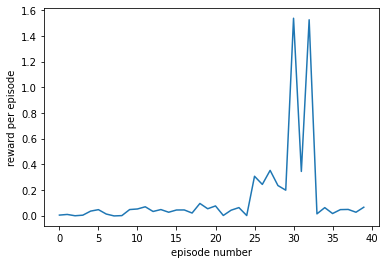

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.max(re_3[-100:])))
plt.plot(list(range(len(re_3))), re_3)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

Average reward of last 100 episodes is 162


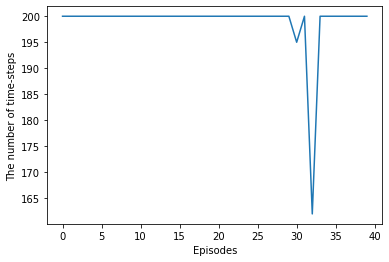

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.min(ste_3[-100:])))
plt.plot(list(range(len(ste_3))), ste_3)
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

### Last trial with discount=0.4 and lr=0.05

In [ ]:
agent_4 = MountainCarAgent(action_size, state_size,discount_factor=0.4, learning_rate=0.05,
                           epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)

In [ ]:
re_4, ste_4, ep_re4, ep_st4=train_agent(agent_4, nam="model_weights_4.h5", rewards_per_episode=[], for_steps=[],
                                        episodes=[],ep_re=0, ep_st=0,update_counter=0,epsilon = 1)
re4=np.array(re_4).max()
ste4=np.array(ste_4).min()

1/1 [==============================] - 0s 15ms/step
episode 0, reward 0.02520953296587425, memory_length 200, Number of Steps 200, epsilon 0.8213543943995963
1/1 [==============================] - 0s 15ms/step
episode 1, reward 0.015322869976291996, memory_length 400, Number of Steps 200, epsilon 0.6742807943399114
1/1 [==============================] - 0s 16ms/step
episode 2, reward -0.011371356867167712, memory_length 600, Number of Steps 200, epsilon 0.5538671150051557
1/1 [==============================] - 0s 17ms/step
episode 3, reward -0.0007257284082557488, memory_length 800, Number of Steps 200, epsilon 0.4552807326425205
1/1 [==============================] - 0s 17ms/step
episode 4, reward -0.0005242652455601619, memory_length 1000, Number of Steps 200, epsilon 0.3745650295675263
1/1 [==============================] - 0s 15ms/step
episode 5, reward -0.011195482320560356, memory_length 1200, Number of Steps 200, epsilon 0.3084806012037175
1/1 [==============================] - 

Average reward of last 100 episodes is 0.02520953296587425


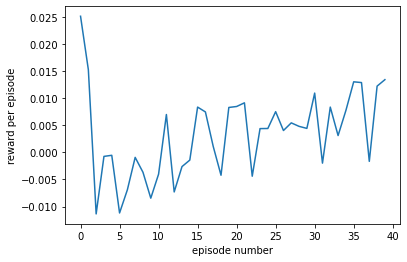

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.max(re_4[-100:])))
plt.plot(list(range(len(re_4))), re_4)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

Average reward of last 100 episodes is 200


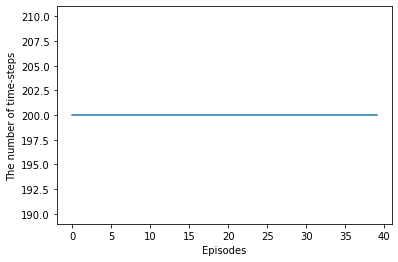

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.min(ste_4[-100:])))
plt.plot(list(range(len(ste_4))), ste_4)
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

## Compare performance of the four trials

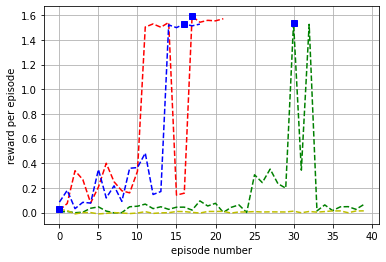

In [ ]:
plt.plot(list(range(len(re_1))), re_1, 'r--',ep_re1, re1, 'bs',label='gamma=0.95,alpha=0.02,epsilon_decay=0.99')
plt.plot(list(range(len(re_2))), re_2, 'b--', ep_re2, re2, 'bs',label='gamma=0.8,alpha=0.005,epsilon_decay=0.99')
plt.plot(list(range(len(re_3))), re_3, 'g--', ep_re3, re3, 'bs',label='gamma=0.6,alpha=0.5,epsilon_decay=0.99')
plt.plot(list(range(len(re_4))), re_4, 'y--', ep_re4, re4, 'bs',label='gamma=0.4,alpha=0.05,epsilon_decay=0.99')
# plt.legend()
plt.grid()
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

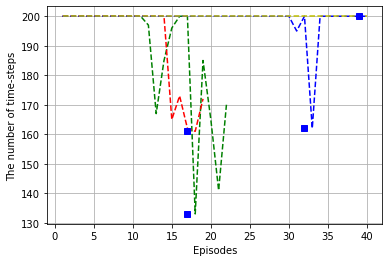

In [ ]:
plt.plot(np.arange(1, len(ste_1)+1), ste_1, 'g--', ep_st1,ste1, 'bs',label='gamma=0.95,alpha=0.02,epsilon_decay=0.99')
plt.plot(np.arange(1, len(ste_2)+1), ste_2, 'r--', ep_st2,ste2, 'bs',label='gamma=0.8,alpha=0.005,epsilon_decay=0.99')
plt.plot(np.arange(1, len(ste_3)+1), ste_3, 'b--', ep_st3,ste3, 'bs',label='gamma=0.6,alpha=0.5,epsilon_decay=0.99')
plt.plot(np.arange(1, len(ste_4)+1), ste_4, 'y--', ep_st4,ste4, 'bs',label='gamma=0.4,alpha=0.05,epsilon_decay=0.99')
plt.grid()
# plt.legend()
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

### As we see the optimal solution is the first trial

Average reward of last 100 episodes is 1.5927295427002663


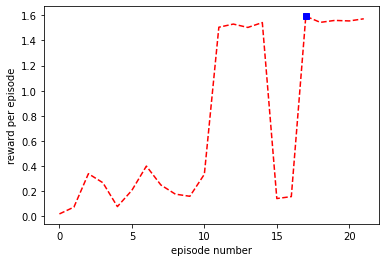

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.max(re_1[-100:])))
plt.plot(list(range(len(re_1))), re_1, 'r--',ep_re1, re1, 'bs')
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

Average reward of last 100 episodes is 133


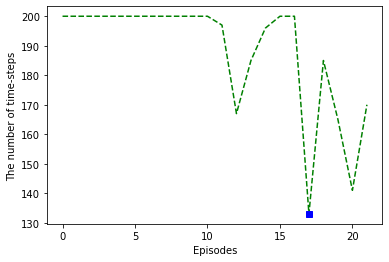

In [ ]:

print("Average reward of last 100 episodes is {0}".format(np.min(ste_1[-100:])))
plt.plot(list(range(len(ste_1))), ste_1, 'g--', ep_st1,ste1, 'bs')
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

## Test The Agent
### Best performance with the first hyperparameters(model_weights_1.h5)

In [1]:
episodes=[]
rewards_per_episode_test=[]
for_steps_test= []

In [2]:
def play_game(ml_model, games=10):
    
    for i_episode in range(games):
        # Define Reward Var
        episode_reward = 0
        steps_test=0

        # Reset Env for the Game
        observation = env.reset()

        while True:
            env.render()

            # Predict Next Movement
            current_action_pred = ml_model.predict(observation.reshape(1, 2))[0]

            # Define Movement
            current_action = np.argmax(current_action_pred)

            # Make Movement
            observation, reward, done, info = env.step(current_action)
            steps_test+=1
            episode_reward += reward 

            if done:
                print(f"Episode finished after {i_episode+1} steps", end='')
                # Update Reward Value
                rewards_per_episode_test.append(episode_reward)
                for_steps_test.append(steps_test)
                break

In [3]:
def build_model():
    init = he_normal(seed = 1000)
    model = Sequential()
    model.add(Dense(48, input_dim=2,kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64,kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(3, activation=LeakyReLU(alpha=0.1),kernel_initializer = init))
    model.compile(loss="mean_squared_error",optimizer=Adam(lr = 0.0001))
    return model

In [ ]:
mymodel = build_model()
mymodel.load_weights("model_weights_1.h5")
play_game(mymodel)

1/1 [==============================] - 0s 15ms/step


C:\Users\Nourhan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 15ms/step
Episode finished after 10 steps

In [ ]:
re_t=np.array(rewards_per_episode_test).max()
ste_t=np.array(for_steps_test).min()

ep_ret = rewards_per_episode_test.index(re_t)
ep_stt = for_steps_test.index(ste_t)

### Reward per episode

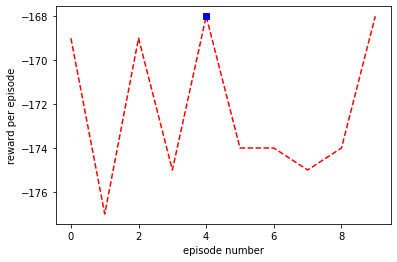

In [ ]:
plt.plot(list(range(len(rewards_per_episode_test))), rewards_per_episode_test, 'r--',  ep_ret,re_t, 'bs')
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

### No. of time-steps per episode

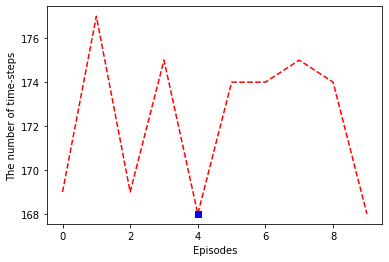

In [ ]:
plt.plot(np.arange(len(for_steps_test)), for_steps_test, 'r--',  ep_stt,ste_t, 'bs')
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()